In [125]:
# import packages for data processing
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer

# import packages for URL parsing
from urllib.parse import urlparse
from collections import Counter
import re
import tldextract
import ipaddress

# import packages for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# import packages for statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency

# import packages for model building


# set display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [126]:
# load training data
df_extracted = pd.read_csv('dataset/train.csv')

In [127]:
# decompose URL into its components
def decompose_single_url(url):
    parsed = urlparse(url)
    hostname = parsed.hostname or None
    ext = tldextract.extract(hostname) if hostname else None
    
    return {
        'url': url,
        'protocol': parsed.scheme or None,
        'hostname': hostname,
        'subdomains': ext.subdomain if ext else None,
        'sld': ext.domain if ext else None,
        'tld': ext.suffix if ext else None,
    }

def decompose_url(df):
    df_decomposed = df['url'].apply(lambda x: pd.Series(decompose_single_url(x)))
    df_decomposed = pd.concat([df_decomposed, df['target']], axis=1)
    # convert all empty strings to None
    df_decomposed.replace('', None, inplace=True)
    # transform url such that we truncate off at hostname level
    # def reconstruct_base_url(row):
    #     if not row['hostname']:
    #         return row['url']  # return original if parsing failed
    #     protocol = row['protocol'] if row['protocol'] else 'http'
    #     return f"{protocol}://{row['hostname']}"
    # df_decomposed['url'] = df_decomposed.apply(reconstruct_base_url, axis=1)
    return df_decomposed

In [128]:
# feature engineering, extracting features from URL
def extract_url_features(df):

    final_df = df.copy()

    ## PROTOCOL FEATURES
    final_df['is_https'] = (final_df['protocol'] == 'https').astype(int)
    final_df['is_http'] = (final_df['protocol'] == 'http').astype(int)

    ## DOMAIN FEATURES
    final_df['has_subdomain'] = final_df['subdomains'].notna().astype(int)
    final_df['has_tld'] = final_df['tld'].notna().astype(int)
    final_df['num_subdomain'] = final_df['subdomains'].apply(lambda x: len(x.split('.')) if x else 0)
    # check if is IP address
    def is_ip_address(hostname):
        try:
            ipaddress.ip_address(hostname)
            return 1  
        except:
            return 0
    final_df['is_domain_ip'] = final_df['hostname'].apply(is_ip_address)
    # detect punycode
    final_df['is_punycode'] = final_df['hostname'].str.contains('xn--', regex=False, na=False).astype(int)

    ## LENGTH FEATURES
    final_df['length_url'] = final_df['url'].str.len()
    final_df['length_hostname'] = final_df['hostname'].str.len()
    final_df['length_subdomains'] = final_df['subdomains'].str.len()
    final_df['length_tld'] = final_df['tld'].str.len()
    final_df['length_sld'] = final_df['sld'].str.len()

    ## PUNCTUATION FEATURES
    final_df['num_dots'] = final_df['url'].str.count(r'\.')
    final_df['num_hyphens'] = final_df['url'].str.count('-')
    final_df['num_at'] = final_df['url'].str.count('@')
    final_df['num_question_marks'] = final_df['url'].str.count(r'\?')
    final_df['num_and'] = final_df['url'].str.count('&')
    final_df['num_equal'] = final_df['url'].str.count('=')
    final_df['num_underscores'] = final_df['url'].str.count('_')    
    final_df['num_slashes'] = final_df['url'].str.count('/')
    final_df['num_percent'] = final_df['url'].str.count('%')
    final_df['num_dollars'] = final_df['url'].str.count(r'\$')
    final_df['num_colon'] = final_df['url'].str.count(':')
    final_df['num_semicolon'] = final_df['url'].str.count(';')
    final_df['num_comma'] = final_df['url'].str.count(',')
    final_df['num_hashtag'] = final_df['url'].str.count('#')
    final_df['num_tilde'] = final_df['url'].str.count('~')

    ## SUSPICIOUS PATTERNS FEATURES
    final_df['tld_in_subdomain'] = final_df['subdomains'].apply(lambda x: 1 if x and any(ext in x for ext in ['.com', '.net', '.org']) else 0)
    final_df['subdomain_longer_sld'] = (final_df['length_subdomains'] > final_df['length_sld']).astype(int)

    ## RATIO FEATURES
    final_df['ratio_digits_hostname'] = final_df['hostname'].apply(lambda x: sum(c.isdigit() for c in x) / len(x) if len(x) > 0 else 0)
    final_df['ratio_letter_hostname'] = final_df['hostname'].apply(lambda x: sum(c.isalpha() for c in x) / len(x) if len(x) > 0 else 0)
    final_df['ratio_special_char_hostname'] = final_df['hostname'].apply(lambda x: sum(not c.isalnum() and c not in ['/', ':', '.'] for c in x) / len(x) if len(x) > 0 else 0)
    
    # WORD-BASED FEATURES 
    words_host = final_df['hostname'].apply(lambda x: re.findall(r'\w+', x) if x else [])
    final_df['length_words_hostname'] = words_host.apply(len)
    final_df['avg_word_hostname'] = words_host.apply(lambda x: np.mean([len(w) for w in x]) if x else 0)

    ## CHARACTER BASED FEATURES
    final_df['num_unique_chars_hostname'] = final_df['hostname'].apply(lambda x: len(set(x)) if x else 0)
    final_df['num_unique_chars_subdomains'] = final_df['subdomains'].apply(lambda x: len(set(x)) if x else 0)
    final_df['num_unique_chars_sld'] = final_df['sld'].apply(lambda x: len(set(x)) if x else 0)
    final_df['num_non_ascii_hostname'] = final_df['hostname'].apply(lambda x: sum(1 for c in x if ord(c) > 127) if x else 0)
    final_df['longest_repeated_char_hostname'] = final_df['hostname'].apply(lambda x: max([len(list(g)) for k, g in re.findall(r'((.)\2*)', x)]) if x else 0)
    final_df['longest_repeated_char_subdomains'] = final_df['subdomains'].apply(lambda x: max([len(list(g)) for k, g in re.findall(r'((.)\2*)', x)]) if x else 0)
    final_df['longest_repeated_char_sld'] = final_df['sld'].apply(lambda x: max([len(list(g)) for k, g in re.findall(r'((.)\2*)', x)]) if x else 0)

    # URL SHORTENING FEATURES
    shortening_services = ['bit.ly', 'goo.gl', 'tinyurl', 't.co']
    final_df['has_shortened_hostname'] = final_df['hostname'].str.lower().apply(lambda x: 1 if any(service in x for service in shortening_services) else 0)
    
    # ENTROPY FEATURES
    def calculate_entropy(domain):
        if not domain or len(domain) == 0:
            return 0
        domain_clean = re.sub(r'[^a-z]', '', domain.lower())
        if len(domain_clean) == 0:
            return 0
        char_freq = Counter(domain_clean)
        entropy = -sum((count/len(domain_clean)) * np.log2(count/len(domain_clean)) 
                      for count in char_freq.values())
        return entropy
    final_df['entropy_hostname'] = final_df['hostname'].apply(calculate_entropy)
    final_df['entropy_subdomains'] = final_df['subdomains'].apply(calculate_entropy)
    final_df['entropy_sld'] = final_df['sld'].apply(calculate_entropy)

    
    return final_df

In [129]:
# section 2 function
def run_section_2(df):
    df_decomposed = decompose_url(df)
    df_features = extract_url_features(df_decomposed)
    return df_features

In [130]:
df_extracted = run_section_2(df_extracted)

In [131]:
# check num_subdomain distribution print
subdomain_counts = df_extracted['has_subdomain'].value_counts().sort_index()
print("Subdomain Counts Distribution:")
print(subdomain_counts)

Subdomain Counts Distribution:
has_subdomain
0    2108
1    7035
Name: count, dtype: int64


In [132]:
df_extracted.columns

Index(['url', 'protocol', 'hostname', 'subdomains', 'sld', 'tld', 'target',
       'is_https', 'is_http', 'has_subdomain', 'has_tld', 'num_subdomain',
       'is_domain_ip', 'is_punycode', 'length_url', 'length_hostname',
       'length_subdomains', 'length_tld', 'length_sld', 'num_dots',
       'num_hyphens', 'num_at', 'num_question_marks', 'num_and', 'num_equal',
       'num_underscores', 'num_slashes', 'num_percent', 'num_dollars',
       'num_colon', 'num_semicolon', 'num_comma', 'num_hashtag', 'num_tilde',
       'tld_in_subdomain', 'subdomain_longer_sld', 'ratio_digits_hostname',
       'ratio_letter_hostname', 'ratio_special_char_hostname',
       'length_words_hostname', 'avg_word_hostname',
       'num_unique_chars_hostname', 'num_unique_chars_subdomains',
       'num_unique_chars_sld', 'num_non_ascii_hostname',
       'longest_repeated_char_hostname', 'longest_repeated_char_subdomains',
       'longest_repeated_char_sld', 'has_shortened_hostname',
       'entropy_hostname', '

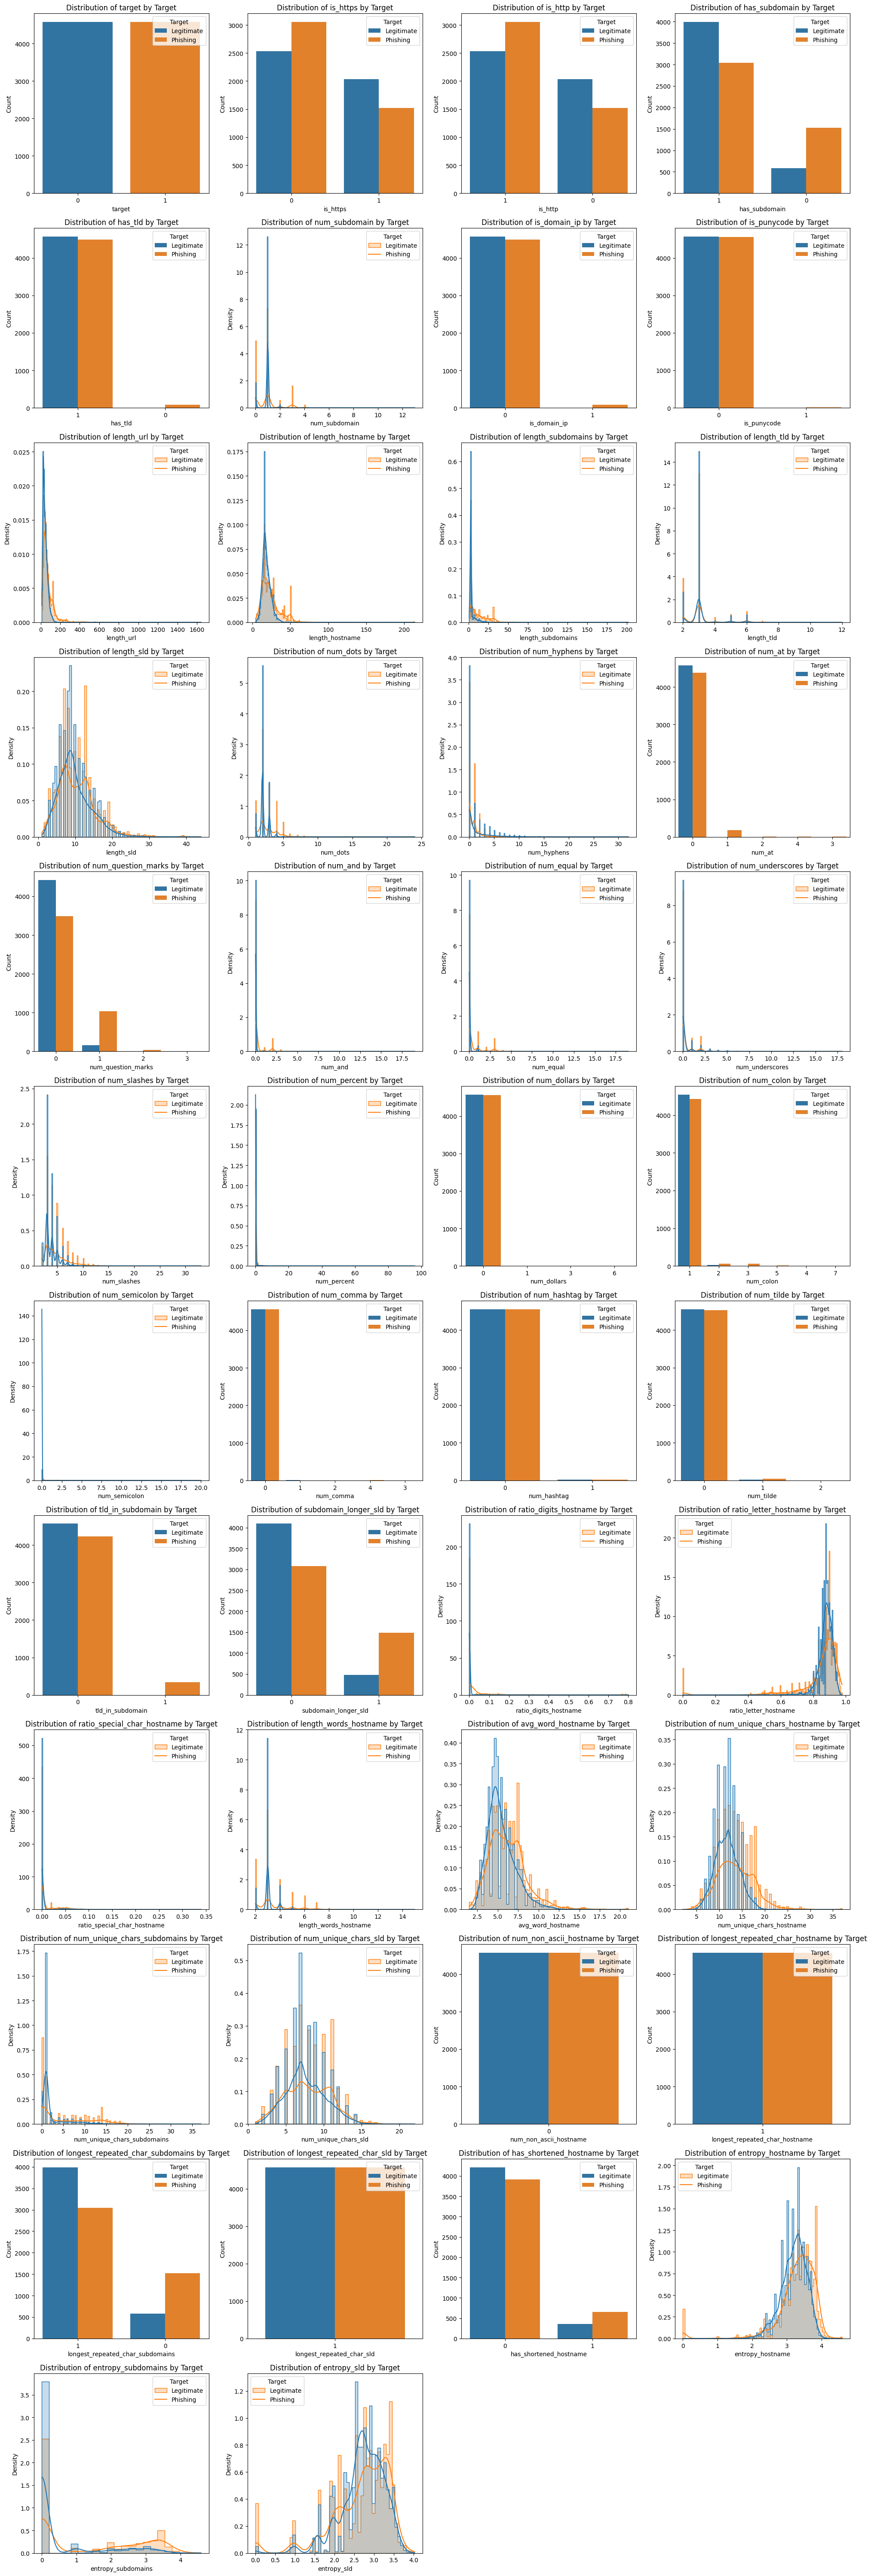

In [133]:
# plot distribution of all features with hue = target
import seaborn as sns
import matplotlib.pyplot as plt

# get all feature cols that are numerical or integer or boolean
feature_cols = df_extracted.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()

# set 4 columns layout
n_cols = 4
n_rows = (len(feature_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

# Strategy for visualising features:
# - Discrete/binary-like features (few unique values) use countplot for clearer counts.
# - Continuous-like features (many unique values) use histplot with KDE enabled.
# - Keep KDE enabled only for numeric features with sufficiently many unique values and catch failing gaussian_kde.
DISCRETE_THRESHOLD = 8  # treat features with <= this many unique values as discrete

for i, col in enumerate(feature_cols):
    col_series = df_extracted[col].dropna()
    unique_count = col_series.nunique()
    is_numeric = pd.api.types.is_numeric_dtype(df_extracted[col])

    if unique_count <= DISCRETE_THRESHOLD or not is_numeric:
        # Discrete feature — show counts per category; convert numeric categories to str for visual grouping
        order = col_series.value_counts().index
        sns.countplot(data=df_extracted, x=col, hue='target', order=order, ax=axes[i])
        axes[i].set_ylabel('Count')
    else:
        # Continuous feature — histogram + KDE (if safe)
        kde_eligible = True  # we've already ensured good variability by unique_count
        try:
            sns.histplot(
                data=df_extracted,
                x=col,
                hue='target',
                kde=kde_eligible,
                element='step',
                stat='density',
                common_norm=False,
                ax=axes[i]
            )
        except np.linalg.LinAlgError:
            sns.histplot(
                data=df_extracted,
                x=col,
                hue='target',
                kde=False,
                element='step',
                stat='density',
                common_norm=False,
                ax=axes[i]
            )

    axes[i].set_title(f'Distribution of {col} by Target')
    axes[i].set_xlabel(col)
    # Legend labels — ensure Int -> readable category mapping
    if isinstance(df_extracted['target'].dtype, (pd.CategoricalDtype,)) or df_extracted['target'].dtype == 'int64':
        axes[i].legend(title='Target', labels=['Legitimate', 'Phishing'])
    else:
        axes[i].legend(title='Target')

for i in range(len(feature_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [141]:
def engineer_features(df):

    final_df = df.copy()

    # ------------------------------
    # HTTP + Many Subdomains
    # ------------------------------
    # Attackers often use many nested subdomains to mimic legitimate domains
    # combined with unsecured HTTP. Real websites rarely have both.
    final_df['is_http_and_many_subdomains'] = (
        (final_df['is_http'] == 1) & (final_df['num_subdomain'] > 2)
    ).astype(bool)

    # ------------------------------
    # IP Address + Short TLD
    # ------------------------------
    # Legitimate domains usually have standard TLDs (.com, .net, .org, all 3-letter TLDs) and are rarely accessed via IP.
    # URLs with an IP or suspiciously short/missing TLD are highly suspicious.
    final_df['ip_and_short_tld'] = (
        final_df['is_domain_ip'] & (final_df['length_tld'] <= 2)
    ).astype(bool)

    # ------------------------------
    # HTTP + Missing Domain Structure
    # ------------------------------
    # URLs without subdomains or with very short SLD AND using HTTP are unusual.
    # Captures low-information, suspicious URLs with minimal domain structure.
    final_df['http_and_missing_domain_info'] = (
        (final_df['is_http'] == 1) &
        (final_df['has_subdomain']) &
        (final_df['length_sld'] <= 3)
    ).astype(bool)

    # ------------------------------
    # Subdomain Depth × HTTP
    # ------------------------------
    # Multiplies subdomain depth by HTTP usage to capture the intensity of suspicion.
    # Deep subdomains are more suspicious if served over HTTP.
    final_df['subdomain_depth_x_http'] = (
        final_df['num_subdomain'] * final_df['is_http']
    )

    # ------------------------------
    # IP × Protocol interactions
    # ------------------------------
    # Using an IP instead of a hostname is suspicious.
    # Combining with protocol amplifies signal:
    # - IP + HTTP is especially suspicious
    # - IP + HTTPS is rare but still unusual (not using, zero variance in dataset)
    final_df['ip_x_http'] = (final_df['is_domain_ip'] * final_df['is_http']).astype(bool)
    # final_df['ip_x_https'] = (final_df['is_domain_ip'] * final_df['is_https']).astype(bool)

    # ------------------------------
    # Domain Complexity Score
    # ------------------------------
    # Aggregates multiple weak signals into a single interpretable score:
    # - More subdomains → more suspicious
    # - Unusually short TLD (≤2 chars, likely missing or invalid) → suspicious
    # - IP usage → highly suspicious
    # Higher score → more complex / suspicious domain
    final_df['domain_complexity_score'] = (
        final_df['num_subdomain'] +
        (final_df['length_tld'] <= 2).astype(int) +
        final_df['is_domain_ip'] * 2
    )

    # Normalized domain complexity score (0 to 1 scale)
    max_complexity = final_df['num_subdomain'].max() + 1 + 2  # max subdomains + short TLD + IP
    final_df['domain_complexity_score'] = final_df['domain_complexity_score'] / max_complexity

    # ------------------------------
    # Suspicion Score
    # ------------------------------
    # Rule-based aggregate of key red flags:
    # - HTTP protocol
    # - Many subdomains
    # - IP usage
    # - Short/missing TLD (≤2 characters)
    # Higher score → more suspicious. Interpretable for stakeholders.
    final_df['suspicion_score'] = (
        final_df['is_http'] * 2 +
        (final_df['num_subdomain'] > 2).astype(int) * 2 +
        final_df['is_domain_ip'].astype(int) * 3 +
        (final_df['length_tld'] <= 2).astype(int) * 2
    )

    # Normalized suspicion score (0 to 1 scale)
    max_score = 9  # Maximum possible suspicion score based on above weights
    final_df['suspicion_score'] = final_df['suspicion_score'] / max_score

    return final_df


In [142]:
# add engineered features and plot new features
df_extracted = engineer_features(df_extracted)
df_extracted.columns

Index(['url', 'protocol', 'hostname', 'subdomains', 'sld', 'tld', 'target',
       'is_https', 'is_http', 'has_subdomain', 'has_tld', 'num_subdomain',
       'is_domain_ip', 'is_punycode', 'length_url', 'length_hostname',
       'length_subdomains', 'length_tld', 'length_sld', 'num_dots',
       'num_hyphens', 'num_at', 'num_question_marks', 'num_and', 'num_equal',
       'num_underscores', 'num_slashes', 'num_percent', 'num_dollars',
       'num_colon', 'num_semicolon', 'num_comma', 'num_hashtag', 'num_tilde',
       'tld_in_subdomain', 'subdomain_longer_sld', 'ratio_digits_hostname',
       'ratio_letter_hostname', 'ratio_special_char_hostname',
       'length_words_hostname', 'avg_word_hostname',
       'num_unique_chars_hostname', 'num_unique_chars_subdomains',
       'num_unique_chars_sld', 'num_non_ascii_hostname',
       'longest_repeated_char_hostname', 'longest_repeated_char_subdomains',
       'longest_repeated_char_sld', 'has_shortened_hostname',
       'entropy_hostname', '

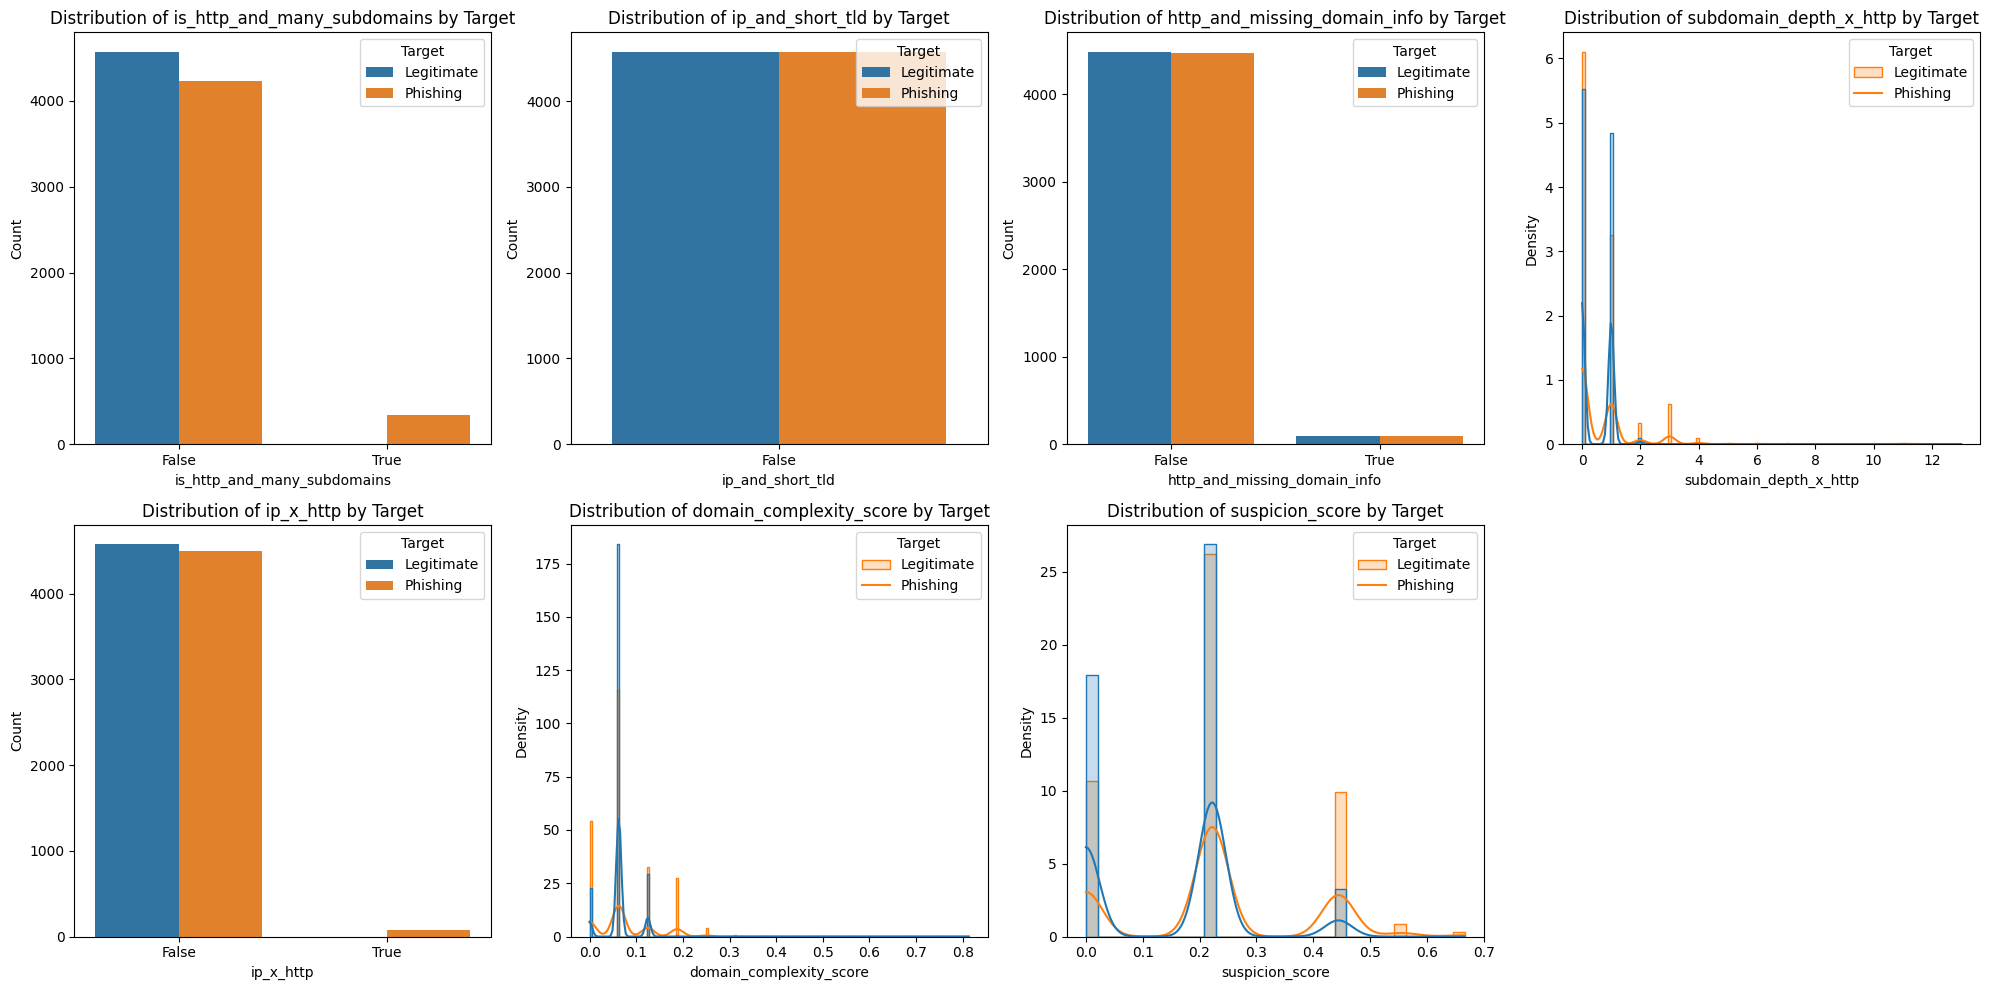

In [143]:
new_features = [
    'is_http_and_many_subdomains',
    'ip_and_short_tld',
    'http_and_missing_domain_info',
    'subdomain_depth_x_http',
    'ip_x_http',
    # 'ip_x_https',
    'domain_complexity_score',  
    'suspicion_score'
]

# plot distribution of new features with hue = target
import seaborn as sns
import matplotlib.pyplot as plt
# set 4 columns layout
n_cols = 4
n_rows = (len(new_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()
for i, col in enumerate(new_features):
    if df_extracted[col].nunique() <= 2:
        sns.countplot(data=df_extracted, x=col, hue='target', ax=axes[i])
        axes[i].set_ylabel('Count')
    else:
        sns.histplot(
            data=df_extracted,
            x=col,
            hue='target',
            kde=True,
            element='step',
            stat='density',
            common_norm=False,
            ax=axes[i]
        )
    axes[i].set_title(f'Distribution of {col} by Target')
    axes[i].set_xlabel(col)
    axes[i].legend(title='Target', labels=['Legitimate', 'Phishing'])
for i in range(len(new_features), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()